In [25]:
  #!/usr/bin/env python

try:
    import gi
    gi.require_version('NumCosmo', '1.0')
    gi.require_version('NumCosmoMath', '1.0')
except:
    pass

import math
import matplotlib.pyplot as plt
from gi.repository import GObject
from gi.repository import NumCosmo as nc
from gi.repository import NumCosmoMath as ncm
import numpy as np
from astropy.io import fits
from astropy.table import Table
import sys
sys.path.insert(0,'/home/henrique/Programas_Cosmologia/CLCosmo_Sim/cluster_abundance/')
sys.path.insert(0,'../scripts')

import pyccl as ccl
%load_ext autoreload
%autoreload 2
import CL_COUNT_class_cluster_abundance as cl_count

from nc_ccl import create_nc_obj, ccl_cosmo_set_high_prec

ncm.cfg_init()
ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


initialize the `Cosmological models`

In [26]:
#CCL cosmology
cosmo_ccl = ccl.Cosmology(Omega_c = 0.30711 - 0.048254, Omega_b = 0.048254, h = 0.677, sigma8 = 0.8822714165197718, n_s=0.96, Omega_k = 0, transfer_function='eisenstein_hu')
ccl_cosmo_set_high_prec (cosmo_ccl)

cosmo, dist, ps_lin, ps_nln, hmfunc = create_nc_obj (cosmo_ccl)

psf = hmfunc.peek_psf ()

initialize the `ClusterAbundance` object

In [27]:
#Numcosmo Cluster Abundance

#First we need to define the multiplicity function here we will use the tinker
mulf = nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp (True)
mulf.set_mdef(nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200)
#Second we need to construct a filtered power spectrum 

hmf = nc.HaloMassFunction.new(dist,psf,mulf)
hmf.set_area((0.25)*4*np.pi)

#Here we define the mass proxy in the first analysis is used the true mass and redshift of the clusters
cluster_m = nc.ClusterMass.new_from_name("NcClusterMassNodist{'lnM-min':<%20.15e>, 'lnM-max':<%20.15e>}" % (math.log(10)*np.log10(1e14),math.log(10)*np.log10(1e16)))
cluster_z = nc.ClusterRedshift.new_from_name("NcClusterRedshiftNodist{'z-min': <%20.15e>, 'z-max':<%20.15e>}" % (0.25,1.5))

ca = nc.ClusterAbundance.new(hmf,None)
mset = ncm.MSet.new_array([cosmo,cluster_m,cluster_z])
mset.pretty_log()
print('sigma8 = '+str(cosmo.sigma8(psf)))

#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  67.7                [FIXED]
#   -     Omegac[01]:  0.258856            [FIXED]
#   -     Omegak[02]:  0                   [FIXED]
#   -    Tgamma0[03]:  2.725               [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.048254            [FIXED]
#   -         w0[07]: -1                   [FIXED]
#   -         w1[08]:  0                   [FIXED]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#----------------------------------------------------------------------------------
# Model parameters
#   - ln10e10ASA[00

In [28]:
#CCL Cluster Abundance
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncTinker08(cosmo_ccl, mass_def=massdef)
clc.set_cosmology(cosmo = cosmo_ccl, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25)*4*np.pi

# Binned approach
Compute the 2D integral

$$
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\log_{10}M_\beta}^{\log_{10}M_{\beta + 1}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}d\log_{10}M
$$

In [29]:
#Bins definition
z_nodes = np.linspace(0.25, 1.25, 16)
log10M_nodes = np.linspace(14, 14.8, 11)
lnM_nodes = log10M_nodes * math.log(10)

#Numcosmo cluster counts in the bins

Numcosmo_Abundance = []
ca.prepare (cosmo, cluster_z, cluster_m)
for zl, zu in zip (z_nodes, z_nodes[1:]):
    nc_bin_mass = []
    for lnMl, lnMu in zip (lnM_nodes, lnM_nodes[1:]):
        Pbin = ca.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnMl], [lnMu], None, [zl], [zu], None)
        nc_bin_mass.append(Pbin)
    Numcosmo_Abundance.append(nc_bin_mass)

#Numcosmo_Abundance[i][j] is the number of clusters in i-th z_bin and j-th mass_bin

In [30]:
#CCL cluster count in the bins
CCL_Abundance_exact = clc.Cluster_Abundance_MZ(zbin_edges = z_nodes, proxybin_edges = log10M_nodes, method = 'exact')

#CCL_Abundance_exact[i][j] is the number of clusters in i-th z_bin and j-th mass_bin

In [31]:
for zl, zu, ccl_a_z, nc_a_z in zip(z_nodes, z_nodes[1:], CCL_Abundance_exact, Numcosmo_Abundance):
    for lnMl, lnMu, ccl_a, nc_a in zip (lnM_nodes, lnM_nodes[1:], ccl_a_z, nc_a_z):
        print("(% 16.9g % 16.9g) (% 16.9g % 16.9g) % 16.9g cmp %.2e" % (lnMl / math.log(10), lnMu / math.log(10), zl, zu, ccl_a, math.fabs (nc_a/ccl_a - 1.0)))


(              14            14.08) (            0.25      0.316666667)       2701.96529 cmp 3.75e-03
(           14.08            14.16) (            0.25      0.316666667)       2107.68818 cmp 4.46e-03
(           14.16            14.24) (            0.25      0.316666667)       1626.01183 cmp 2.71e-03
(           14.24            14.32) (            0.25      0.316666667)       1238.79595 cmp 4.08e-04
(           14.32             14.4) (            0.25      0.316666667)       930.502162 cmp 5.11e-05
(            14.4            14.48) (            0.25      0.316666667)       687.803679 cmp 1.07e-03
(           14.48            14.56) (            0.25      0.316666667)       499.241333 cmp 1.31e-03
(           14.56            14.64) (            0.25      0.316666667)       354.974132 cmp 2.87e-05
(           14.64            14.72) (            0.25      0.316666667)       246.555773 cmp 6.12e-04
(           14.72             14.8) (            0.25      0.316666667)        166

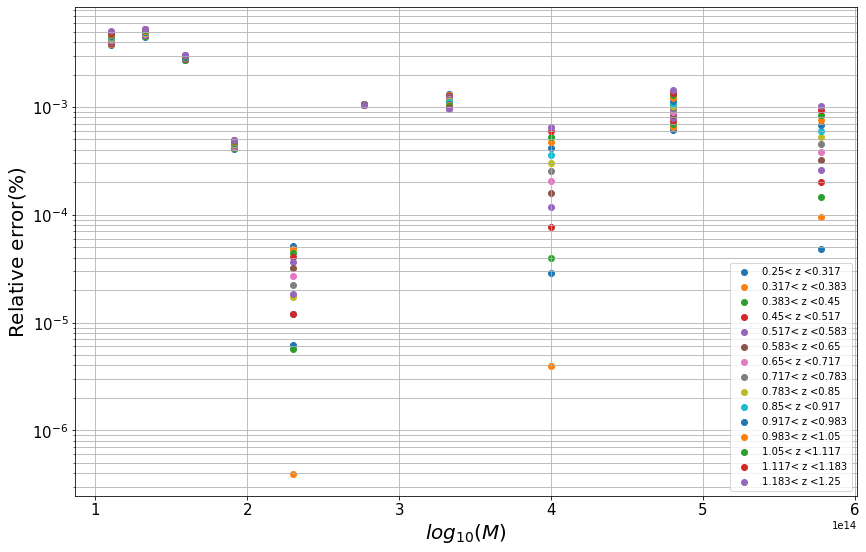

In [32]:
diff = []
for i in range(len(CCL_Abundance_exact)):
        diff.append(abs((Numcosmo_Abundance[i]-CCL_Abundance_exact[i])/Numcosmo_Abundance[i]))


plt.figure(figsize = (14,9))
plt.yscale('log')
z_ = [np.mean([z_nodes[i],z_nodes[i+1]]) for i in np.arange(len(z_nodes)-1)]
mass = [np.mean([10**log10M_nodes[i],10**log10M_nodes[i+1]]) for i in np.arange(len(log10M_nodes)-1)]
plt.tick_params(axis='both', which="both", labelsize= 15)
legend = []
for i in range(len(z_)):
        plt.scatter(mass, diff[:][i])
        legend.append(str(round(z_nodes[i],3))+'< z <'+str(round(z_nodes[i+1],3)))
plt.legend(legend,loc =4, fontsize = 10)
plt.grid(True, which="both" )
plt.ylabel(r'Relative error$(\%)$', fontsize = 20)
plt.xlabel(r'$log_{10}(M)$', fontsize = 20)
plt.show()



#diff[i][j] is the percentual difference between Numcosmo and CCL cluster abundance in i-th z_bin and j-th mass_bin

# Un-binned approach

Compute $$\frac{d^2V(z_i)}{dz d\Omega}\frac{dn(M_i,z_i)}{d\log_{10}M_i}$$ for each masses and redshifts in a dark matter halo catalog

In [33]:
#Generates cluster count catalog data
ncdata = nc.DataClusterNCount.new(ca)
rng = ncm.RNG.pool_get("example_ca_sampling");
ncdata.init_from_sampling(mset,(0.25)*4*np.pi,rng)
ncdata.catalog_save("ca_nodist_binned_numcosmo.fits", True)

ncdata_fits = fits.open('ca_nodist_binned_numcosmo.fits')
#ncdata_fits.info()

ncdata_data =  ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
ncdata_Table.columns
ncdata_Table.sort('Z_TRUE')

display(ncdata_Table)

Z_OBS,LNM_OBS,Z_TRUE,LNM_TRUE
float64,float64,float64,float64
0.250009449557836,32.78789182566977,0.250009449557836,32.78789182566977
0.25000969695398745,33.50132650469467,0.25000969695398745,33.50132650469467
0.25001243747761787,33.434771660226765,0.25001243747761787,33.434771660226765
0.2500152744227828,32.61918334900457,0.2500152744227828,32.61918334900457
0.25002229915903257,32.77494386629897,0.25002229915903257,32.77494386629897
0.25004809604235123,32.926557710293906,0.25004809604235123,32.926557710293906
0.2500496791151745,32.5362726233162,0.2500496791151745,32.5362726233162
0.25005243247562176,32.631119667971106,0.25005243247562176,32.631119667971106
0.25007418038132173,32.516659047587495,0.25007418038132173,32.516659047587495


In [34]:
#Using Numcosmo
d2n = []
for i in ncdata_Table:
    d2n.append(ca.d2n(cosmo,cluster_z,cluster_m,i[1],i[0]))
d2n = np.array(d2n)
d2n


array([ 96161.69407412,  30391.13487744,  34208.09777707, ...,
        61722.36481622,  92779.97563449, 122851.94943584])

In [35]:
#Using CCL
log10M = np.array(ncdata_Table[1][:]/np.log(10))
multiplicity_exact = clc.multiplicity_function_individual_MZ(z = np.array(ncdata_Table[0][:]), logm =log10M, method = 'exact')
multiplicity_exact *= clc.sky_area/math.log(10)
print(multiplicity_exact)

[ 96292.06017878  30419.9306878   34255.01630497 ...  61834.85961297
  93184.54797932 123554.7043426 ]


Text(0, 0.5, 'Relative error $(\\%)$')

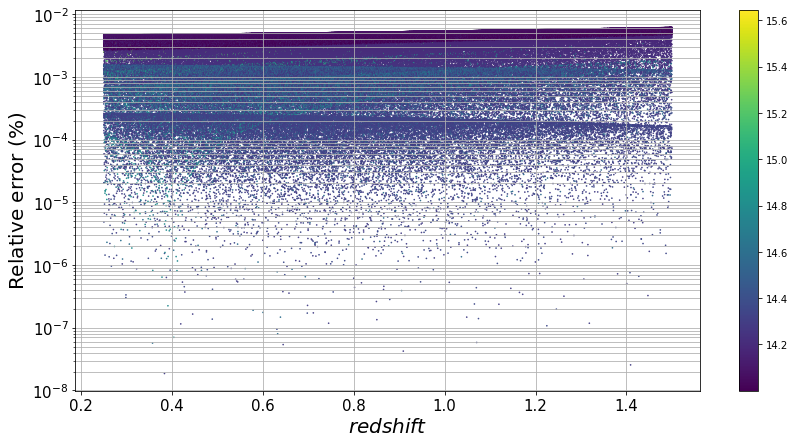

In [36]:
diff = abs((multiplicity_exact-d2n)/d2n)

plt.figure(figsize = (14,7))
plt.yscale('log')
plt.tick_params(axis='both', which = 'major', labelsize= 15)
plt.scatter(ncdata_Table[0][:], diff, s = 0.4, c = log10M)
plt.colorbar()
plt.grid(True, which='both')
plt.xlabel(r'$redshift$', fontsize = 20)
plt.ylabel(r'Relative error $(\%)$', fontsize = 20)
